# Test Trained GAN

[Text(0.5, 1.0, 'wind')]

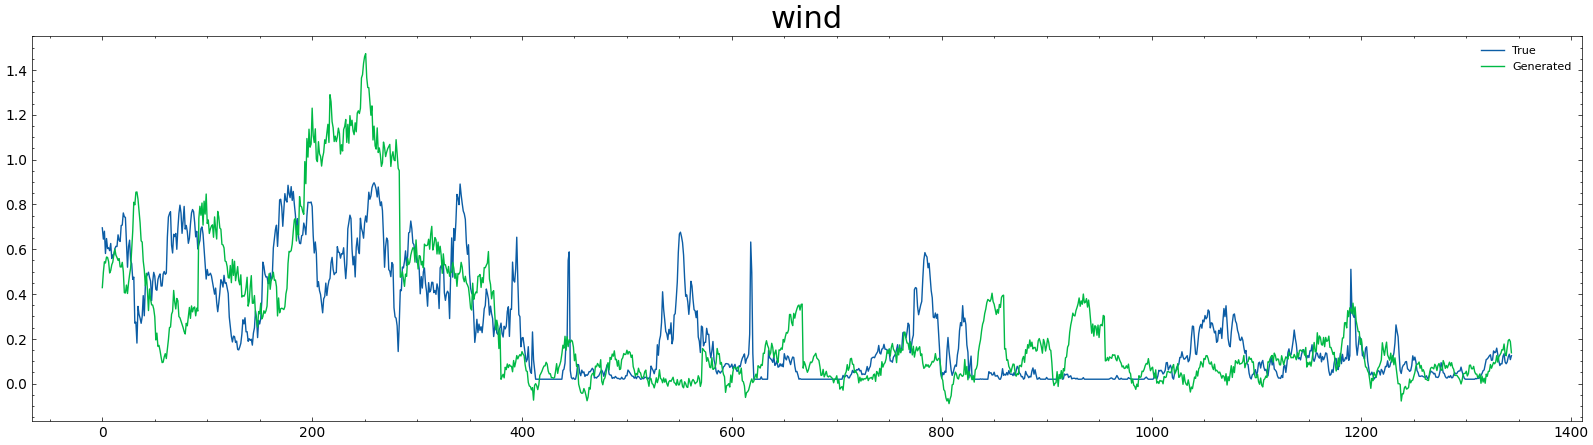

In [27]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scienceplots
plt.style.use(['science', 'no-latex', "nature"])
plt.rcParams.update({
    'axes.labelsize': 15,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlesize": 22,
    "legend.fontsize": 8
})

power_type = "wind"
condition = True
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
test_ds = mydata["test_ds"]
test_ds = test_ds.astype(float)

generator = torch.load(f"loggings/{power_type}_C{condition}_G.pth")
generator.eval()
final_results = []

for i in range(len(test_ds)):
    select = i


    target = test_ds[select, :96]
    cond = test_ds[select, 96:].reshape(1, -1)

    cond = torch.from_numpy(cond).float().cuda()

    num = 1
    dist = 1e10
    idx = 0
    record = []
    for i in range(num):
        z = torch.normal(0, 1, [1, 96]).cuda()
        # break
        y_hat = generator(z, cond)
        y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
        y_hat = y_hat.astype(float)
        if np.linalg.norm(y_hat - target) < dist:
            dist = np.linalg.norm(y_hat - target)
            idx = i
        record.append(y_hat)
    best_fit = record[idx]
    final_results.append(best_fit)
final_results = np.concatenate(final_results, axis=0)

start = 100
plot_len = 96 * 14
end = start + plot_len
fig, ax = plt.subplots(figsize=[20, 5])
ax.plot(range(plot_len), test_ds[:, :96].flatten()[start:end], label="True")
ax.plot(range(plot_len), final_results[start:end], label="Generated")
ax.legend()
ax.set(title=f"{power_type}")


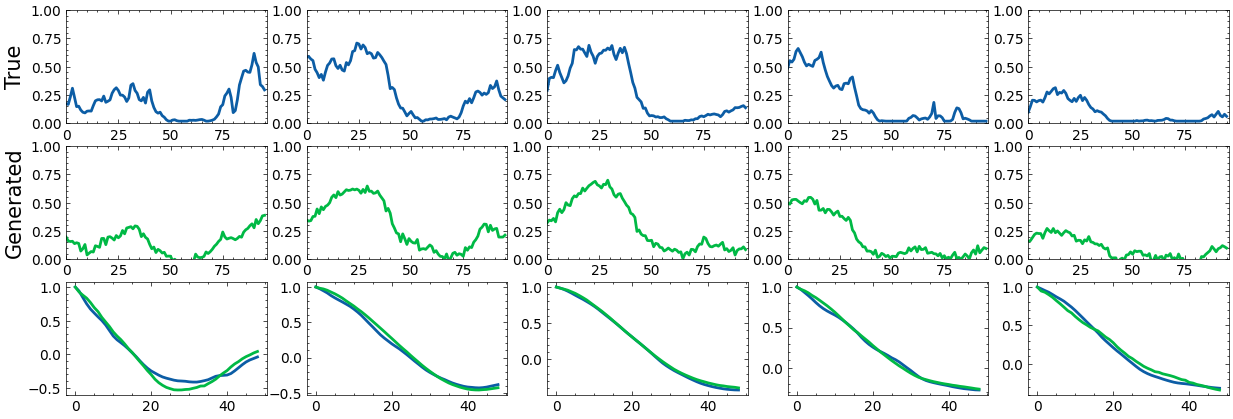

In [28]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils import autocor
import scienceplots

plt.style.use(['science', 'no-latex', "nature"])
plt.rcParams.update({
    'axes.labelsize': 15,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlesize": 22,
    "legend.fontsize": 8
})

power_type = "wind"
condition = True
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
test_ds = mydata["test_ds"]
test_ds = test_ds.astype(float)

generator = torch.load(f"loggings/{power_type}_C{condition}_G.pth")
generator.eval()

final_results = []
final_tests = []
choose = 5

for i in range(choose):
    select = np.random.randint(len(test_ds) - 1)
    target = test_ds[select, :96]
    cond = test_ds[select, 96:].reshape(1, -1)
    cond = torch.from_numpy(cond).float().cuda()

    num = 2500
    dist = 1e10
    idx = 0
    record = []
    for i in range(num):
        z = torch.normal(0, 1, [1, 96]).cuda()
        # break
        y_hat = generator(z, cond)
        y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
        y_hat = y_hat.astype(float)
        if np.linalg.norm(y_hat - target) < dist:
            dist = np.linalg.norm(y_hat - target)
            idx = i
        record.append(y_hat)
    best_fit = record[idx]
    final_results.append(best_fit)
    final_tests.append(target)

fig, axs = plt.subplots(3, choose, figsize=[15, 5])
for j in range(choose):
    atc_tgt = autocor(final_tests[j], lags=48, plot=False)
    atc_best = autocor(final_results[j], lags=48, plot=False)

    axs[0, j].plot(range(len(final_tests[j])),
                   final_tests[j],
                   label="True",
                   lw=2)
    if j == 0:
        axs[0, j].set(ylabel="True")
        axs[1, j].set(ylabel="Generated")
    axs[1, j].plot(range(len(final_results[j])),
                   final_results[j],
                   label="Generated",
                   lw=2,
                   color="C1")
    axs[2, j].plot(range(len(atc_tgt)),
                   atc_tgt,
                   label="True",
                   lw=2)
    axs[2, j].plot(range(len(atc_tgt)),
                   atc_best,
                   label="Generated",
                   lw=2)
    axs[0, j].set(xlim=(0, 96), ylim=(0, 1))
    axs[1, j].set(xlim=(0, 96), ylim=(0, 1))

# fig.savefig(f"data/{power_type}_gen.png", dpi=300, transparent=True)




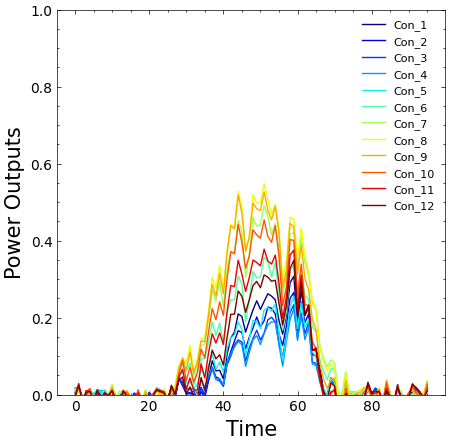

In [31]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from sklearn.preprocessing import StandardScaler

power_type = "pv"
condition = True
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
test_ds = mydata["test_ds"]
test_ds = test_ds.astype(float)

generator = torch.load(f"loggings/{power_type}_C{condition}_G.pth")
generator.eval()

final_results = []
z = torch.normal(0, 1, [1, 96]).cuda()

# ##################################
# ############# Wind ###############
# ##################################

# for i in range(5):
#     select = np.random.randint(len(test_ds) - 1)
#     cond = np.eye(5)[i].reshape(1, -1)
#     print(cond)
#     cond = torch.from_numpy(cond).float().cuda()
#     y_hat = generator(z, cond)
#     y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
#     y_hat = y_hat.astype(float)
#     final_results.append(y_hat)

#################################
############# PV ################
#################################
for i in range(12):
    select = np.random.randint(len(test_ds) - 1)
    cond = [np.sin(2 * np.pi * (i + 1) / 12), np.cos(2 * np.pi * (i + 1) / 12)]
    cond = np.array(cond).reshape(1, -1)
    cond = torch.from_numpy(cond).float().cuda()
    y_hat = generator(z, cond)
    y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
    y_hat = y_hat.astype(float)
    final_results.append(y_hat)


NCURVES = len(final_results)
np.random.seed(101)

values = range(NCURVES)
fig, ax = plt.subplots(figsize=[5, 5])

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(NCURVES):
    colorVal = scalarMap.to_rgba(values[i])
    colorText = (
        'color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2])
        )
    retLine  = ax.plot(range(96), final_results[i], label=f"Con_{i+1}", color=(colorVal[0],colorVal[1],colorVal[2]))
    ax.legend()
    ax.set(xlabel="Time", ylabel="Power Outputs", ylim=(0, 1))
# fig.savefig(f"data/noise_{power_type}_2.png", transparent=True, dpi=300)


# Evaluation

correlation dist: 0.0480054272733238
W dist: 0.009956631860079604


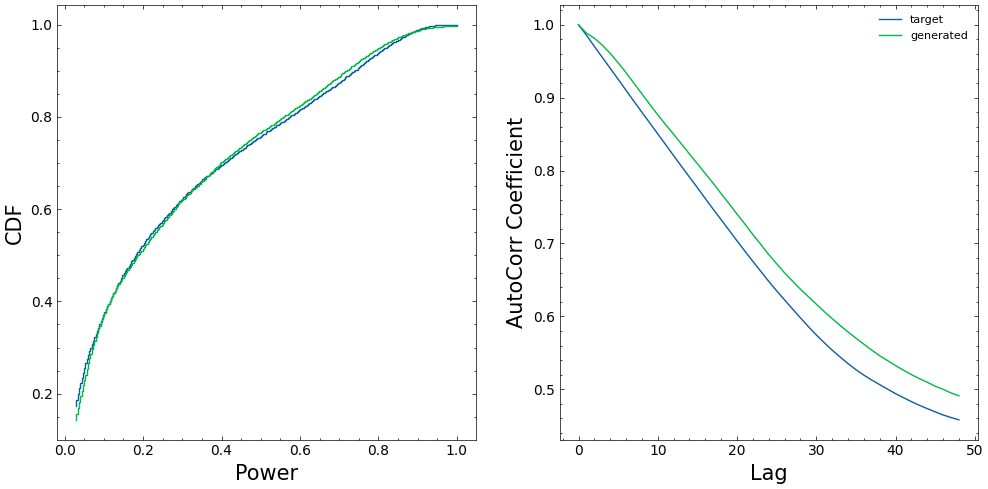

In [24]:
from utils import autocor, cdf, psd, ws_dist, cor_dist, dtw_dist
import numpy as np

target = test_ds[:, :96].flatten()
best_fit = final_results

fig, ax = plt.subplots(1, 2, figsize=[10, 5])
fn_target = cdf(target)
fn_fit = cdf(best_fit)
x = np.linspace(0.03, 1, 300)
ax[0].step(x, fn_target(x), label="target")
ax[0].step(x, fn_fit(x), label="generated")
ax[0].set(ylabel="CDF", xlabel="Power")

atc_tgt = autocor(target, lags=48, plot=False)
atc_best = autocor(best_fit, lags=48, plot=False)
ax[1].plot(range(len(atc_tgt)), atc_tgt, label="target")
ax[1].plot(range(len(atc_tgt)), atc_best, label="generated")
ax[1].set(ylabel="AutoCorr Coefficient", xlabel="Lag")

# atc_tgt, freq_tgt = psd(target)
# atc_best, freq_best = psd(best_fit)
# ax[1][0].plot(freq_tgt, atc_tgt, label="target")
# ax[1][0].plot(freq_best, atc_best, label="generated")

ax[1].legend()
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
print("correlation dist:", cor_dist(target, best_fit))
print("W dist:", ws_dist(target, best_fit))
# fig.savefig("data/pv_eval.png", transparent=True, dpi=300)
